tobac example: Tracking of precipitation features
===
This example notebook demonstrates the use of tobac to track precipitation features in the Tibetan Plateau region based on the satellite data product GPM IMERG. 

The simulation results used in this example were performed as part of

The data used in this example is downloaded from 

**Import necessary python libraries:**

In [3]:
# Import libraries
import iris
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
import urllib,zipfile,shutil
%matplotlib inline

In [4]:
# Import tobac itself
import tobac
from tobac import utils

In [5]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

**Load Data from other Precip example:**

In [67]:
data_out=os.path.join('/media/juli/Data/third_pole/tobac/examples/climate-processes-tobac_example_data-b3e69ee/','data')
data_file=os.path.join(data_out,'Example_input_Precip.nc')

In [68]:
Precip=iris.load_cube(data_file,'surface_precipitation_average')

In [69]:
#display information about the iris cube containing the surface precipitation data:
display(Precip)

Surface Precipitation Average (mm h-1),time,south_north,west_east
Shape,47,198,198
Dimension coordinates,,,
time,x,-,-
south_north,-,x,-
west_east,-,-,x
Auxiliary coordinates,,,
projection_y_coordinate,-,x,-
y,-,x,-
latitude,-,x,x
longitude,-,x,x


# Alternative calculation of spacings when only latitude and longitude values are available 

In [12]:
from math import cos, sin, asin, sqrt, radians

def get_spacings(Precip):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # get min and max values of lats and lons 
    lat1= np.min(Precip.coord('latitude').points[0])
    lat2= np.max(Precip.coord('latitude').points[0])

    lon1= np.min(Precip.coord('longitude').points[0])
    lon2= np.max(Precip.coord('longitude').points[0])
    
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula, note that value is divided by nr of grid cells along lat and lon 
    dlon = (lon2 - lon1) / np.shape(Precip.data)[1]
    dlat = (lat2 - lat1)/ np.shape(Precip.data)[2]
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    metres= np.round(km * 1000)
    
    return metres


In [10]:
metres = get_spacings(Precip)

# Read in GPM precip data 

In [12]:
#data_out = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/high_resolution'
data_out=os.path.join('/media/juli/Data/third_pole/tobac/examples/climate-processes-tobac_example_data-b3e69ee/','data')
data_file=os.path.join(data_out,'gpmimerg_ttaxis.nc4')
data_file= '/media/juli/Data/third_pole/satellite_data/gpm_v06/2000/gpm_imerg_200006_tobac_input.nc4'
Precip=iris.load_cube(data_file,'precipitationCal')
Precip.attributes = None

In [33]:
#Set up directory to save output and plots:
savedir='/media/juli/Data/third_pole/satellite_data/gpm_v06/Save'
plot_dir="/media/juli/Data/third_pole/satellite_data/gpm_v06/Plot"

In [9]:
display(Precip)

Precipitationcal (mm/hr),time,longitude,latitude
Shape,1440,351,181
Dimension coordinates,,,
time,x,-,-
longitude,-,x,-
latitude,-,-,x


# Parameters

## Feature detection 

In [27]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features={}
parameters_features['position_threshold']='weighted_diff' # diff between specific value and threshold for weighting when finding the center location (instead of just mean lon/lat)
parameters_features['min_num']=3 #? 
parameters_features['min_distance']=0 # minimum distance between features 

parameters_features['sigma_threshold']=0.5 # for slightly smoothing (gaussian filter)
parameters_features['n_erosion_threshold']=0 # pixel erosion (for more robust results)

parameters_features['threshold']=[1,2,3,4,5,7,10,15] #mm/h, step-wise threshold for feature detection 
parameters_features['n_min_threshold']=10 # minimum nr of contiguous pixels for thresholds, 10 pixels = ca. 2000 km2

## Segmentation 

In [28]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=1  # mm/h mixing ratio (until which threshold the area is taken into account)

## Tracking

In [17]:
dxy,dt=tobac.get_spacings(Precip)


Available coordinates:     ['time', 'longitude', 'latitude']


In [19]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']= 1000 # maximum size of subnetwork used for linking 
parameters_linking['memory']=0
parameters_linking['time_cell_min']= 6*dt 
parameters_linking['method_linking']='predict'
#parameters_linking['method_detection']='threshold'
parameters_linking['v_max']= 10
#parameters_linking['d_min']=2000
parameters_linking['d_min']=4*dxy # four times the grid spacing  (! seems to be important for GPM data)

# Chunking

In [34]:
# get list with all files by month
import glob
file_list= glob.glob('/media/juli/Data/third_pole/satellite_data/gpm_v06/????/*tobac_input.nc4')  
print('files in dataset:  ', len(file_list))

files in dataset:   226


In [35]:
for file in file_list:
    i = file[66:72]
    print('start process for file.....', file)
    ## DATA PREPARATION
    Precip=iris.load_cube(file,'precipitationCal')
    dxy,dt=tobac.get_spacings(Precip)
    
    # FEATURE DETECTION
    print('starting feature detection based on multiple thresholds')
    Features=tobac.feature_detection_multithreshold(Precip,dxy,**parameters_features)
    print('feature detection done')
    Features.to_hdf(os.path.join(savedir,'Features' + str(i) + '.h5'),'table')
    print('features saved')
    
    # SEGMENTATION 
    print('Starting segmentation based on surface precipitation')
    Mask,Features_Precip=tobac.segmentation_2D(Features,Precip,dxy,**parameters_segmentation)
    print('segmentation based on surface precipitation performed, start saving results to files')
    iris.save([Mask],os.path.join(savedir,'Mask_Segmentation_precip' + str(i) + '.nc'),zlib=True,complevel=4)                
    Features_Precip.to_hdf(os.path.join(savedir,'Features_Precip' + str(i) + '.h5'),'table')
    print('segmentation surface precipitation performed and saved')

start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2014/gpm_imerg_201402_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2014/gpm_imerg_201403_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data

segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2000/gpm_imerg_200012_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2001/gpm_imerg_200102_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving re

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2002/gpm_imerg_200206_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2002/gpm_imerg_200207_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2003/gpm_imerg_200312_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2004/gpm_imerg_200401_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2005/gpm_imerg_200506_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2005/gpm_imerg_200507_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2006/gpm_imerg_200612_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2007/gpm_imerg_200702_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2008/gpm_imerg_200804_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2008/gpm_imerg_200807_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2009/gpm_imerg_200912_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2010/gpm_imerg_201002_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2011/gpm_imerg_201106_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2011/gpm_imerg_201107_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2012/gpm_imerg_201212_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2013/gpm_imerg_201302_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2015/gpm_imerg_201506_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2015/gpm_imerg_201507_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2016/gpm_imerg_201612_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2017/gpm_imerg_201702_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2018/gpm_imerg_201806_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detection done
features saved
Starting segmentation based on surface precipitation
segmentation based on surface precipitation performed, start saving results to files
segmentation surface precipitation performed and saved
start process for file..... /media/juli/Data/third_pole/satellite_data/gpm_v06/2018/gpm_imerg_201807_tobac_input.nc4
Available coordinates:     ['time', 'longitude', 'latitude']
starting feature detection based on multiple thresholds
feature detect

## Difference between Features and Features_Precip

= Features_Precip containts column "ncells" which describes the number of cells of the segment 

In [288]:
Features_Precip = Features

In [290]:
file= savedir  + '/Features201405.h5'
file= savedir  + '/Features_Precip201404.h5'
features_p = pd.read_hdf(file, 'table')


# Trajectory linking with chunked features 

In [63]:
# read in HDF5 files with saved features
import glob 
from netCDF4 import Dataset

filelist= glob.glob(savedir  + '/Features_Precip??????.h5')
filelist.sort()
file_list= []


# only choose years from 2006 to 2016 
for year in np.arange(2006,2017):    
    for file in filelist:
        if str(year) in file:
            file_list.append(file)


## Recombination of dataframes with update of frame number

In [64]:
i = 0 
end_frame =0 
for file in file_list: 
    if i == 0:
        print(file)
        features_p = pd.read_hdf(file, 'table')
        Features = features_p
        i +=1
        # read in data mask with segments for tracked cells 
        date= file[len(file)-9: len(file)-3]
        ds = Dataset(savedir + '/Mask_Segmentation_precip'+date+'.nc')
        mask = np.array(ds['segmentation_mask'])  
        end_frame += np.shape(mask)[0] -1 
        #end_frame =  np.max(features_p['frame']) + 1 
    else:
        features = pd.read_hdf(file, 'table')
        # update frame number and make sure they are sequential! 
        features['frame'] = features['frame']  + end_frame
        # append dataframes 
        Features = Features.append(features, ignore_index=True)
        # update last number in frame 
        
        # read in data mask with segments for tracked cells 
        date= file[len(file)-9: len(file)-3]
        ds = Dataset(savedir+ '/Mask_Segmentation_precip'+date+'.nc')
        mask = np.array(ds['segmentation_mask'])  
        end_frame += np.shape(mask)[0]
        #end_frame = np.max(features['frame']) + 1
        print(np.shape(mask), end_frame)


/media/juli/Data/third_pole/satellite_data/gpm_v06/Save/Features_Precip200601.h5
(1344, 351, 181) 2831
(1488, 351, 181) 4319
(1440, 351, 181) 5759
(1488, 351, 181) 7247
(1440, 351, 181) 8687
(1488, 351, 181) 10175
(1488, 351, 181) 11663
(1440, 351, 181) 13103
(1488, 351, 181) 14591
(1440, 351, 181) 16031
(1488, 351, 181) 17519
(1488, 351, 181) 19007
(1344, 351, 181) 20351
(1488, 351, 181) 21839
(1440, 351, 181) 23279
(1488, 351, 181) 24767
(1440, 351, 181) 26207
(1488, 351, 181) 27695
(1488, 351, 181) 29183
(1440, 351, 181) 30623
(1488, 351, 181) 32111
(1440, 351, 181) 33551
(1488, 351, 181) 35039
(1488, 351, 181) 36527
(1392, 351, 181) 37919
(1488, 351, 181) 39407
(1440, 351, 181) 40847
(1488, 351, 181) 42335
(1440, 351, 181) 43775
(1488, 351, 181) 45263
(1488, 351, 181) 46751
(1440, 351, 181) 48191
(1488, 351, 181) 49679
(1440, 351, 181) 51119
(1488, 351, 181) 52607
(1488, 351, 181) 54095
(1344, 351, 181) 55439
(1488, 351, 181) 56927
(1440, 351, 181) 58367
(1488, 351, 181) 59855
(144

In [65]:
Features.shape

(2312139, 12)

# Tracking for only one time chunk

In [12]:
file = savedir + '/Features_Precip201507.h5'
Features= pd.read_hdf(file, 'table')

In [27]:
Track=tobac.linking_trackpy(Features,Precip,dt=dt,dxy=dxy,**parameters_linking)
Track.to_hdf(os.path.join(savedir,'Tracks_GPM_201507.h5'),'table')

Frame 1487: 19 trajectories present.


# Visualisation of one time chunk

In [32]:
from netCDF4 import Dataset
file= savedir  + '/Mask_Segmentation_precip201507.nc'
ds = Dataset(file)
Mask = np.array(ds['segmentation_mask'])  


In [40]:
 Mask,Features_Precip=tobac.segmentation_2D(Features,Precip,dxy,**parameters_segmentation)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

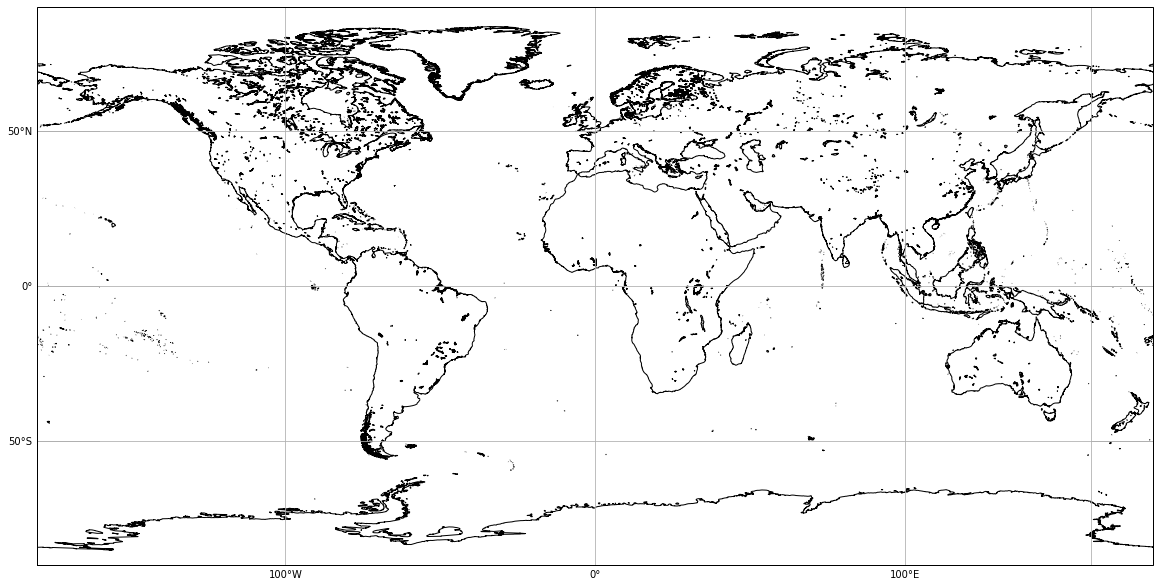

In [46]:
from tobac import plotting
import cartopy.crs as ccrs
axis_extent= [70, 110, 25.0, 45 ]
fig_map,ax_map=plt.subplots(figsize=(20,20),subplot_kw={'projection': ccrs.PlateCarree()})
plotting.plot_tracks_mask_field(Track,Precip,Mask,Features, extend = axis_extent, axes = ax_map )

# Perform tracking with merged features 

In [70]:
Track=tobac.linking_trackpy(Features,Precip,dt=dt,dxy=dxy,**parameters_linking)
# remove NaN tracks from feature space! 
Track = Track.loc[Track.cell > 0]
Track.to_hdf(os.path.join(savedir,'Tracks_GPM_2006_2016.h5'),'table')

Frame 192860: 2 trajectories present.


# Read in Tracks which have already been calculated 

In [72]:
file = savedir + '/Tracks_GPM_2006_2016.h5'
Track = pd.read_hdf(file, 'table')

In [84]:
Features['timestr']=pd.to_datetime(Features['timestr'],format='%Y-%m-%d %H:%M:%S')
Features.loc[Features['timestr'].dt.strftime('%Y-%m') == '2016-06']

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells


In [78]:
Track['timestr']=pd.to_datetime(Track['timestr'],format='%Y-%m-%d %H:%M:%S')
Track.loc[Track['timestr'].dt.strftime('%Y-%m') == '2016-06']

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell
2142147,182590,7,221.780117,169.551864,107,1,2,2016-06-01 00:00:00,2016-06-01 00:00:00,92.228012,43.905186,111,761485.0,03:30:00
2142153,182591,9,221.792887,169.450843,98,1,8,2016-06-01 00:30:00,2016-06-01 00:30:00,92.229289,43.895084,95,761485.0,04:00:00
2142161,182592,16,221.992824,169.151757,59,1,16,2016-06-01 01:00:00,2016-06-01 01:00:00,92.249282,43.865174,0,761485.0,04:30:00
2142176,182594,13,273.424737,138.201819,14,2,31,2016-06-01 02:00:00,2016-06-01 02:00:00,97.392472,40.770182,151,761537.0,00:00:00
2142185,182595,12,272.972923,139.241562,56,2,40,2016-06-01 02:30:00,2016-06-01 02:30:00,97.347291,40.874155,231,761537.0,00:30:00
2142194,182596,20,273.553377,139.659017,45,2,49,2016-06-01 03:00:00,2016-06-01 03:00:00,97.405335,40.915902,180,761537.0,01:00:00
2142201,182597,6,273.712087,139.766280,45,2,56,2016-06-01 03:30:00,2016-06-01 03:30:00,97.421206,40.926628,155,761537.0,01:30:00
2142207,182598,6,274.170276,139.838725,36,2,62,2016-06-01 04:00:00,2016-06-01 04:00:00,97.467026,40.933873,161,761537.0,02:00:00
2142214,182599,3,276.464775,141.215984,27,2,69,2016-06-01 04:30:00,2016-06-01 04:30:00,97.696478,41.071598,281,761537.0,02:30:00
2142217,182600,16,278.927063,139.487605,227,1,72,2016-06-01 05:00:00,2016-06-01 05:00:00,97.942703,40.898760,216,761537.0,03:00:00


# Data inspection

In [260]:
# remove NaN tracks from feature space! 
df = Track.loc[Track.cell > 0]
df.shape

(12599, 14)

In [10]:
for t in parameters_features['threshold']:
    # look at  frequencies of tracked systems based on different thresholds 
    subselect= Track.loc[Track['threshold_value'] == t]
    print(t, subselect.shape[0])


1 95679
2 75586
3 47732
4 30305
5 31402
7 18899
10 11418
15 7437


In [261]:
# sort dataframe based on one parameter
Track.sort_values(by= 'num')


,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell
23839,1173,80,250.905024,80.135638,11,1,23840,2014-06-25 10:30:00,2014-06-25 10:30:00,95.140504,34.963564,10,NaN,NaT
16733,927,22,249.108191,13.472779,11,3,16734,2014-06-20 07:30:00,2014-06-20 07:30:00,94.960817,28.297278,28,NaN,NaT
26220,1268,64,223.800133,18.877404,11,1,26221,2014-06-27 10:00:00,2014-06-27 10:00:00,92.430011,28.837741,8,NaN,NaT
16739,927,7,187.945011,58.242339,11,5,16740,2014-06-20 07:30:00,2014-06-20 07:30:00,88.844500,32.774233,26,5336.0,02:00:00
5123,318,20,250.292561,14.801919,11,4,5124,2014-06-07 15:00:00,2014-06-07 15:00:00,95.079259,28.430193,21,1568.0,04:00:00
16747,927,6,237.597177,9.893866,11,10,16748,2014-06-20 07:30:00,2014-06-20 07:30:00,93.809717,27.939387,58,5305.0,05:30:00
26216,1268,42,169.867538,156.682411,11,1,26217,2014-06-27 10:00:00,2014-06-27 10:00:00,87.036756,42.618242,11,NaN,NaT
5115,318,2,2.773559,147.047008,11,2,5116,2014-06-07 15:00:00,2014-06-07 15:00:00,70.327355,41.654702,44,1552.0,04:30:00
16760,928,63,227.360254,11.534905,11,1,16761,2014-06-20 08:00:00,2014-06-20 08:00:00,92.786025,28.103490,11,NaN,NaT
5108,318,10,13.506491,143.283290,11,1,5109,2014-06-07 15:00:00,2014-06-07 15:00:00,71.400647,41.278329,10,NaN,NaT


# Visualisation of longest and heaviest storms

    

In [138]:
# Set extent for maps plotted in the following cells ( in the form [lon_min,lon_max,lat_min,lat_max])
axis_extent=[70.0,105.0,27.0,45.0]        

In [33]:
help(tobac.map_tracks)

Help on function map_tracks in module tobac.plotting:

map_tracks(track, axis_extent=None, figsize=(10, 10), axes=None)



## finding the longest storm 

In [65]:
a =[] 
for c in np.unique(Track.cell):
    a.append(np.shape(Track.loc[Track['cell'] == c ])[0])


In [77]:
arr = np.array(a)
idx = np.where(arr == 47)[0]
arr2 = np.unique(Track.cell)
index = arr2[idx]

In [97]:
subset1 = Track.loc[Track['cell'] == 100319.0]
subset2 = Track.loc[Track['cell'] == 303708.0]

In [167]:
#axis_extent= [72, 82, 27.0, 35]
axis_extent= [70, 105, 27.0, 45]

In [156]:
# read in DEM for background 
from netCDF4 import Dataset

f = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_GPM_format.nc'
ds= Dataset(f)
dem = ds['__xarray_dataarray_variable__']


(181, 351)

In [259]:
# subset tracking for e.g. plotting
subset = Track.loc[Track['cell'] > 0 ]

In [258]:
for c in np.unique(Track.cell):
    if np.shape(Track.loc[Track['cell'] == c])[0] < 3:
        #print('no time persistence for cell', c, 'only: ',np.shape(Track.loc[Track['cell'] == c]))

SyntaxError: unexpected EOF while parsing (<ipython-input-258-d283e06ae7cd>, line 3)

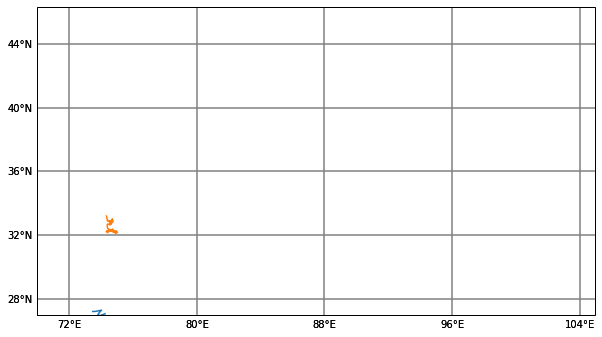

In [171]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
#plt.imshow(dem, cmap = 'gray_r')
ax_map=tobac.map_tracks(subset,axis_extent=axis_extent,axes=ax_map)
ax_map=tobac.map_tracks(subset2,axis_extent=axis_extent,axes=ax_map)

plt.savefig('Plot/tracks_TP_cell200.png')

# Statistics of precipitation features 

In [83]:
from tobac.analysis import lifetime_histogram

def plot_lifetime_histogram(track,bin_edges=np.arange(0,200,20),density=False,**kwargs):
    hist, bin_edges,bin_centers = lifetime_histogram(track,bin_edges=bin_edges,density=density)
    plot_hist=plt.plot(bin_centers, hist,**kwargs)
    return plot_hist

def plot_lifetime_histogram_bar(track,axes=None,bin_edges=np.arange(0,100,20),density=False,width_bar=10,shift=0.5,**kwargs):
    hist, bin_edges, bin_centers = lifetime_histogram(track,bin_edges=bin_edges,density=density)
    plot_hist=plt.bar(bin_centers+shift,hist,width=width_bar,**kwargs)
    return plot_hist

def plot_histogram_cellwise(track,bin_edges,variable,quantity,axes=None,density=False,**kwargs):
    hist, bin_edges,bin_centers = histogram_cellwise(track,bin_edges=bin_edges,variable=variable,quantity=quantity,density=density)
    plot_hist=axes.plot(bin_centers, hist,**kwargs)
    return plot_hist

def plot_histogram_featurewise(Track,bin_edges,variable,axes=None,density=False,**kwargs):
    hist, bin_edges, bin_centers = histogram_featurewise(Track,bin_edges=bin_edges,variable=variable,density=density)
    plot_hist=axes.plot(bin_centers, hist,**kwargs)
    return plot_hist


## TODO 

- lifetimes 
- speeds 
- direction (vector diagram )
- environmental impact: intensity vs.  duration, max rain rate/ duration, max rain rate/ speed
- divide by threshold statistics 

1 23071


<Figure size 432x288 with 0 Axes>

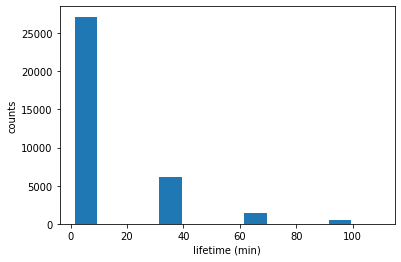

2 10534


<Figure size 432x288 with 0 Axes>

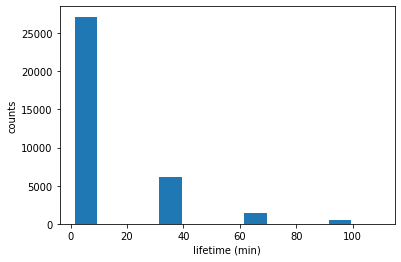

3 5383


<Figure size 432x288 with 0 Axes>

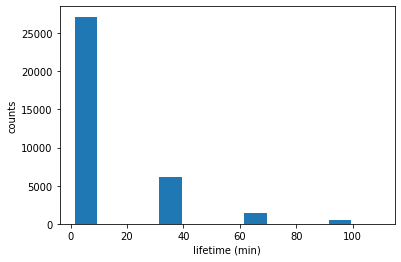

4 3157


<Figure size 432x288 with 0 Axes>

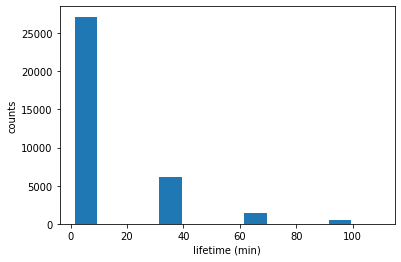

5 4884


<Figure size 432x288 with 0 Axes>

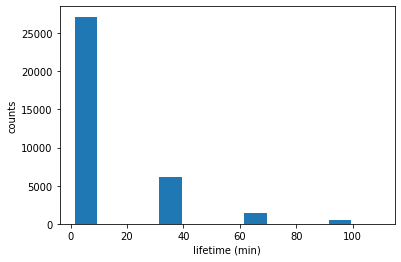

10 1176


<Figure size 432x288 with 0 Axes>

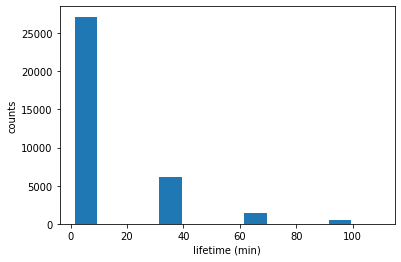

15 675


<Figure size 432x288 with 0 Axes>

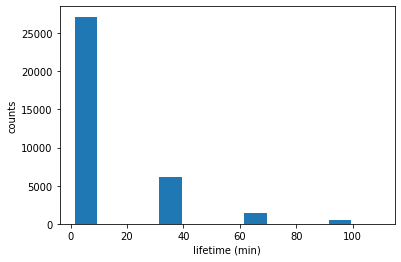

<Figure size 432x288 with 0 Axes>

In [90]:
for t in parameters_features['threshold']:
    # look at  frequencies of tracked systems based on different thresholds 
    subselect= Track.loc[Track['threshold_value'] == t]
    print(t, subselect.shape[0])
    plt.clf()
    
    fig_lifetime,ax_lifetime=plt.subplots()
    tobac.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,120,10),density=False,width_bar=8)
    ax_lifetime.set_xlabel('lifetime (min)')
    ax_lifetime.set_ylabel('counts')
    plt.show()
    plt.savefig('Plot/lifetime_histogram_threshold_' + str(t) + '.png')
 

In [297]:
Track.sort_values(by ='frame')

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell
20,3,11,116.924719,8.268390,21,1,21,2014-03-12 01:30:00,2014-03-12 01:30:00,81.742472,27.776839,32,13.0,00:00:00
27,4,7,118.296173,8.179100,16,2,28,2014-03-12 02:00:00,2014-03-12 02:00:00,81.879615,27.767910,100,13.0,00:30:00
31,5,7,119.479999,7.820160,18,2,32,2014-03-12 02:30:00,2014-03-12 02:30:00,81.998000,27.732016,98,13.0,01:00:00
33,6,7,117.147846,5.615235,93,1,34,2014-03-12 03:00:00,2014-03-12 03:00:00,81.764784,27.511523,95,13.0,01:30:00
39,7,8,116.765918,3.394934,71,1,40,2014-03-12 03:30:00,2014-03-12 03:30:00,81.726592,27.289494,75,13.0,02:00:00
43,8,7,117.720966,1.481708,23,1,44,2014-03-12 04:00:00,2014-03-12 04:00:00,81.822096,27.098170,22,13.0,02:30:00
47,9,5,120.552568,1.153616,15,1,48,2014-03-12 04:30:00,2014-03-12 04:30:00,82.105259,27.065361,15,13.0,03:00:00
51,10,7,122.040705,0.666947,11,1,52,2014-03-12 05:00:00,2014-03-12 05:00:00,82.254070,27.016694,14,13.0,03:30:00
68,30,7,75.456018,57.390703,17,1,69,2014-03-12 15:00:00,2014-03-12 15:00:00,77.595604,32.689071,11,33.0,00:00:00
72,31,4,76.016144,57.221102,27,1,73,2014-03-12 15:30:00,2014-03-12 15:30:00,77.651616,32.672111,28,33.0,00:30:00


In [407]:
nr_traject = np.shape(np.unique(Track.cell))[0]
nr_features = np.shape(Track)[0]


In [342]:
8000/nr_traject*100

24.84240598701984

# Cell stats

In [34]:
track1= Track.loc[Track.threshold_value == 1 ]
track2= Track.loc[Track.threshold_value == 2 ]
track3= Track.loc[Track.threshold_value == 3 ]
track4= Track.loc[Track.threshold_value == 4 ]
track5= Track.loc[Track.threshold_value == 5 ]


In [7]:
track1 = Track 
track2= Track.loc[Track.cell == 33.0]
# subset of tracks with trajectories that contain at least one feature > 10 or > 15 mm/hr: 
for c in np.unique(Track.cell):
    cell= Track.loc[Track.cell == c ]
    if 10 in cell.threshold_value.values or 15 in cell.threshold_value.values:
        track2= track2.append(cell)

In [86]:
track3= Track.loc[Track.cell == 78.0]

In [87]:
for c in np.unique(Track.cell):
    cell= Track.loc[Track.cell == c ]
    if 7 in cell.threshold_value.values or 10 in cell.threshold_value.values or 15 in cell.threshold_value.values:
        track3= track3.append(cell)

In [90]:
track4= Track.loc[Track.cell == 33.0]
# subset of tracks with trajectories that contain at least one feature > 10 or > 15 mm/hr: 
for c in np.unique(Track.cell):
    cell= Track.loc[Track.cell == c ]
    if 15 in cell.threshold_value.values:
        track4= track4.append(cell)

In [12]:
track_small= Track.loc[Track.cell == 33.0]
# subset of tracks with trajectories that contain at least one feature > 10 or > 15 mm/hr: 
for c in np.unique(Track.cell):
    cell= Track.loc[Track.cell == c ]
    if np.sum(np.unique(cell.threshold_value.values)) <= 15:
              track_small= track_small.append(cell)

In [19]:
800/60

13.333333333333334

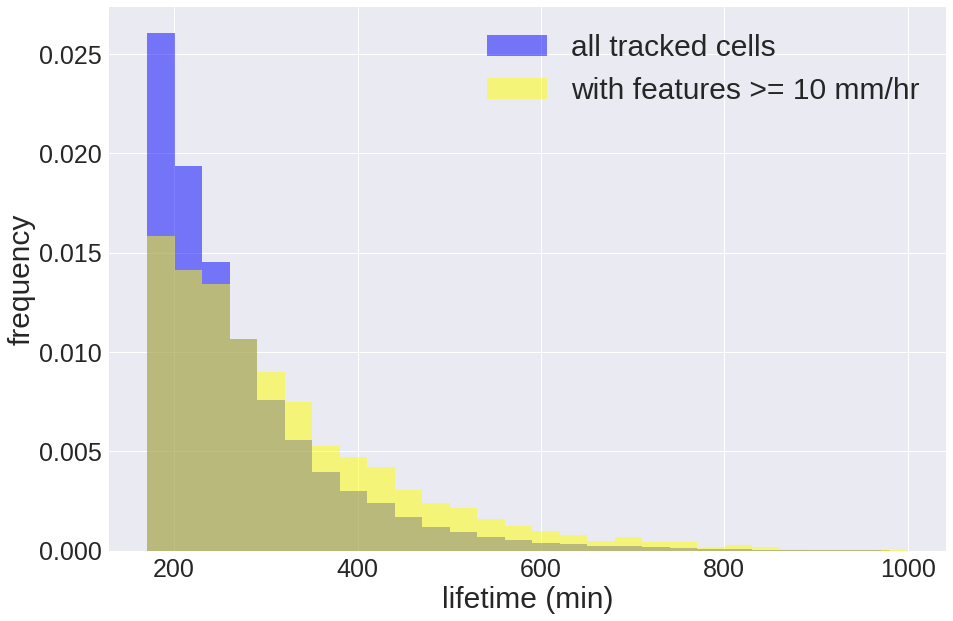

In [18]:
# Lifetimes of tracked features:

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

#plt.figure(figsize=(20, 17))
fig_lifetime, ax_lifetime= plt.subplots(figsize= (15,10))
tobac.plot_lifetime_histogram_bar(track1,axes=ax_lifetime,bin_edges=np.arange(180,1000,10),density=True,width_bar=30, color='blue', alpha=0.5, label='all tracked cells')
tobac.plot_lifetime_histogram_bar(track2,axes=ax_lifetime,bin_edges=np.arange(180,1000,10),density=True,width_bar=30, color='yellow', alpha=0.5, label='with features >= 10 mm/hr')
#tobac.plot_lifetime_histogram_bar(track2,axes=ax_lifetime,bin_edges=np.arange(180,1000,10),density=True,width_bar=30, color='red', alpha=0.5, label='with features > 10 mm/hr')
#tobac.plot_lifetime_histogram_bar(track3,axes=ax_lifetime,bin_edges=np.arange(180,1000,10),density=True,width_bar=30, color='blue', alpha=0.5, label='with features > 7mm/hr')
#tobac.plot_lifetime_histogram_bar(track_small,axes=ax_lifetime,bin_edges=np.arange(180,1000,10),density=True,width_bar=30, color='gray', alpha=0.5, label='with features < =5mm/hr')


ax_lifetime.set_xlabel('lifetime (min)', fontsize= 30)
ax_lifetime.set_ylabel('frequency', fontsize = 30)
plt.legend(fontsize= 30)

# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/lifetime_GPM_ts.png')

# With CNRR 

In [12]:
file = '/media/juli/Data/third_pole/mcs_tracking/CNRR/Save/Tracks_CNRR_2014-2016.h5'
CNRR = pd.read_hdf(file, 'table')

In [13]:

Track['timestr']=pd.to_datetime(Track['timestr'],format='%Y-%m-%d %H:%M:%S')

In [15]:
# extract only 2014 --- 2016 for CNRR and Track 
track= Track
# select only trajectories 2014-2016 
for i,y in enumerate(Track.timestr):
    if y.year not in [2014, 2015, 2016]:
        row = Track.loc[Track.index[i]]
        f= row.frame
        track = track[track.frame != f]


In [14]:
CNRR['timestr']=pd.to_datetime(CNRR['timestr'],format='%Y-%m-%d %H:%M:%S')

In [20]:
cnrr= CNRR
# select only trajectories 2014-2016 
for i,y in enumerate(CNRR.timestr):
    if y.year not in [2014, 2015, 2016]:
        row = CNRR.loc[CNRR.index[i]]
        f= row.frame
        cnrr = cnrr[cnrr.frame != f]


In [117]:
track1 = track 
track2= track.loc[track.cell == 33.0]
# subset of tracks with trajectories that contain at least one feature > 10 or > 15 mm/hr: 
for c in np.unique(track.cell):
    cell= track.loc[track.cell == c ]
    if 10 in cell.threshold_value.values or 15 in cell.threshold_value.values:
        track2= track2.append(cell)
        

In [31]:
# extract tracks with features >= 10 mm/hr 

track3 = cnrr
track4= cnrr.loc[CNRR.cell == 73009.0]
# subset of tracks with trajectories that contain at least one feature > 10 or > 15 mm/hr: 
for c in np.unique(cnrr.cell):
    cell= cnrr.loc[cnrr.cell == c ]
    if 10 in cell.threshold_value.values or 15 in cell.threshold_value.values:
        track4= track4.append(cell)

In [54]:
1000/60

16.666666666666668

In [90]:
timesteps = np.arange(180,20*60,60)

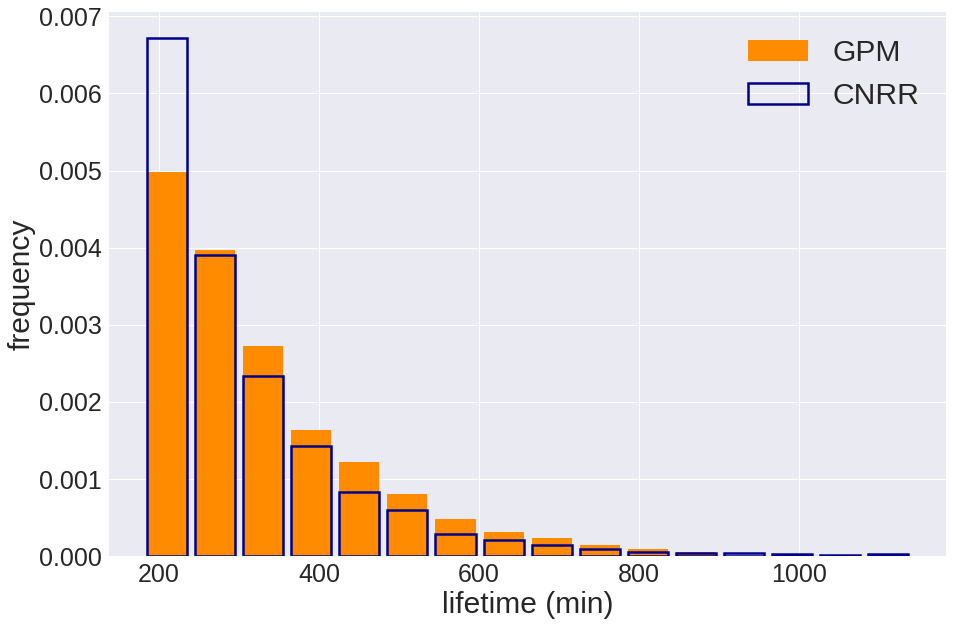

In [129]:
# plot 
#track1= Track 
#track3 = CNRR

# Lifetimes of tracked features:

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

#plt.figure(figsize=(20, 17))
fig_lifetime, ax_lifetime= plt.subplots(figsize= (15,10))

#tobac.plot_lifetime_histogram_bar(track1,axes=ax_lifetime,bin_edges = timesteps,density=True,width_bar=50, color='darkorange', label='GPM')
tobac.plot_lifetime_histogram_bar(track2,axes=ax_lifetime,bin_edges=timesteps,density=True,width_bar=50, color='darkorange', label='GPM')
#tobac.plot_lifetime_histogram_bar(track3,axes=ax_lifetime,bin_edges=timesteps,density=True,width_bar=50,edgecolor='darkblue', color= 'None',linewidth= 2.5, label='CNRR')
tobac.plot_lifetime_histogram_bar(track4,axes=ax_lifetime,bin_edges=timesteps,density=True,width_bar=50, edgecolor='darkblue', color= 'None', linewidth= 2.5,  label='CNRR')


ax_lifetime.set_xlabel('lifetime (min)', fontsize= 30)
ax_lifetime.set_ylabel('frequency', fontsize = 30)
plt.legend(fontsize= 30)

# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/lifetime_CNRR_GPM_>10.png')

In [393]:
# Distribution over travel speeds:

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})


heights, bins = tobac.velocity_histogram(Track, bin_edges=np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
           17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), density=False, method_distance=None, return_values=False)

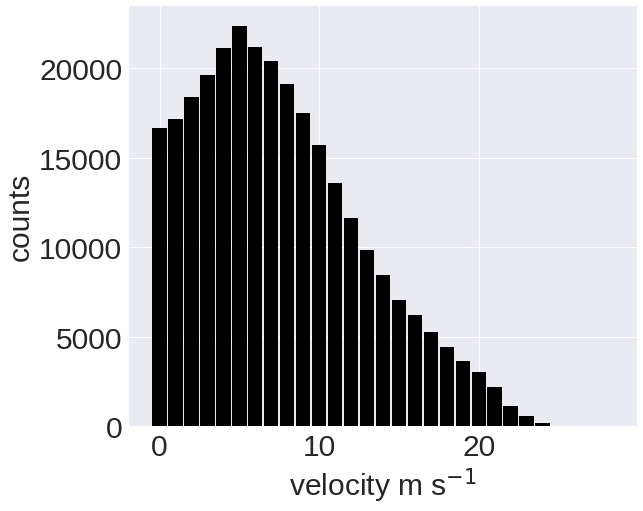

In [441]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
             'xtick.labelsize' : 30,
             'ytick.labelsize' : 30})
plt.figure(figsize=(20, 17))

plt.subplot(2,2,1)
plt.bar(bins[:-1], heights, width = 0.9, color='k')
plt.ylabel('counts', fontsize= 30)
plt.xlabel('velocity m s$^{-1}$', fontsize= 30)

#plt.plot(bins[:-1], heights)


# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/hist_velocity_GPM.png')

## nearest neighborg distance of features 

In [140]:
Features = tobac.calculate_nearestneighbordistance(Features, method_distance=None)
Features.to_hdf(os.path.join(savedir,'Features_merged_nn.h5'),'table')
print('....features nearest neighbordistance saved.')    

....features neareast neighbordistance saved.


In [160]:
Features['min_distance'] /= 1000

In [196]:
bin_edges = np.arange(np.nanmin(Features.min_distance.values), np.nanmax(Features.min_distance.values), 100)

In [197]:
heights, bins= tobac.nearestneighbordistance_histogram(Features, bin_edges = bin_edges)

In [232]:
heights, bins= tobac.nearestneighbordistance_histogram(Features.loc[Features.threshold_value == 1], bin_edges = np.linspace(0,2000,100))
heights10, bins10= tobac.nearestneighbordistance_histogram(Features.loc[Features.threshold_value >= 10], bin_edges = np.linspace(0,2000,100))


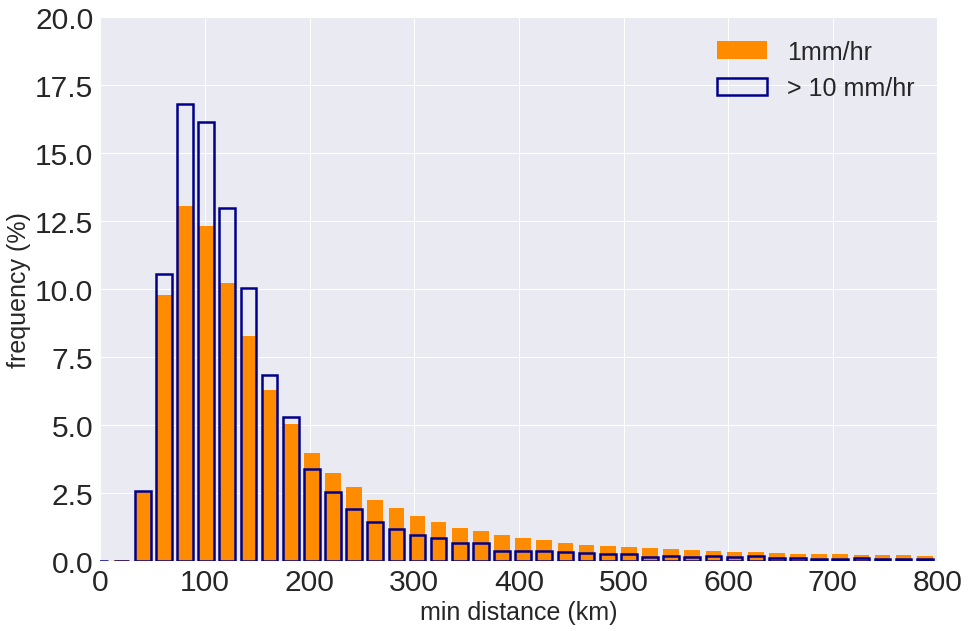

In [238]:

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
             'xtick.labelsize' : 30,'ytick.labelsize' : 30})
plt.figure(figsize=(15, 10))

height = heights/np.sum(heights)
height10 = heights10/np.sum(heights10)

#plt.subplot(2,2,1)
plt.bar(bins[:-1], height*100, width = 15, color='darkorange', label= '1mm/hr')
plt.bar(bins10[:-1], height10*100, width = 15, edgecolor='darkblue', color= 'None',linewidth= 2.5, label= '> 10 mm/hr')
plt.ylim(0,20)
plt.xlim(0,800)
plt.xlabel('min distance (km)', fontsize= 25)
plt.ylabel('frequency (%)', fontsize = 25)
plt.legend(fontsize= 25)

# save figure to image file 
plt.savefig('/media/juli/Data/third_pole/mcs_tracking/tobac_plots/hist_nn_GPM_threshold.png')

# Recombination of mask 

In [378]:

file_list= glob.glob(savedir  + '/Mask_Segmentation_precip??????.nc')  


In [23]:
from netCDF4 import Dataset
file= savedir  + '/Mask_Segmentation_precip201406.nc'
ds = Dataset(file)
mask = np.array(ds['segmentation_mask'])  


In [7]:
datafile= savedir  + '/Mask_Segmentation_precip201406.nc'
mask=iris.load_cube(datafile,'segmentation_mask')

In [8]:
import iris
from iris.analysis.cartography import area_weights

In [15]:
mask.coords('longitude')

[DimCoord(array([ 70.05,  70.15,  70.25,  70.35,  70.45,  70.55,  70.65,  70.75,
         70.85,  70.95,  71.05,  71.15,  71.25,  71.35,  71.45,  71.55,
         71.65,  71.75,  71.85,  71.95,  72.05,  72.15,  72.25,  72.35,
         72.45,  72.55,  72.65,  72.75,  72.85,  72.95,  73.05,  73.15,
         73.25,  73.35,  73.45,  73.55,  73.65,  73.75,  73.85,  73.95,
         74.05,  74.15,  74.25,  74.35,  74.45,  74.55,  74.65,  74.75,
         74.85,  74.95,  75.05,  75.15,  75.25,  75.35,  75.45,  75.55,
         75.65,  75.75,  75.85,  75.95,  76.05,  76.15,  76.25,  76.35,
         76.45,  76.55,  76.65,  76.75,  76.85,  76.95,  77.05,  77.15,
         77.25,  77.35,  77.45,  77.55,  77.65,  77.75,  77.85,  77.95,
         78.05,  78.15,  78.25,  78.35,  78.45,  78.55,  78.65,  78.75,
         78.85,  78.95,  79.05,  79.15,  79.25,  79.35,  79.45,  79.55,
         79.65,  79.75,  79.85,  79.95,  80.05,  80.15,  80.25,  80.35,
         80.45,  80.55,  80.65,  80.75,  80.85,  80.95,

In [379]:
import xarray as xr
i = 0 
for file in file_list: 
    if i == 0:
        print(file)
        mask = xr.open_dataset(file)
        i +=1 
    else:
        print(file)
        new_mask = xr.open_dataset(file)
        # append to previous mask 
        mask = xr.concat((mask, new_mask),  dim = 'time' )
        Mask = mask

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201408.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201510.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201612.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201403.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201404.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201405.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201406.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201407.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201409.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201410.nc
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/

MemoryError: 

- xarray concatention too large for memory, maybe try dask arrays
- chunk by month 